## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## First, I'll define helper methods

In [1]:
def print_image_grid(images, columns=3):
    """
    A helper method for drawing multiple images in a grid
    """
    f = plt.figure(figsize=(20, 40)) # width, height in inches. If not provided, defaults to rc figure.figsize.
    for i, img in enumerate(images):
        splt = plt.subplot(len(images) / columns + 1, columns, i + 1)
        splt.set_title(img[0], fontsize=20)
        if len(img[1].shape) > 2:
            splt.imshow(img[1])
        else:
            splt.imshow(img[1], cmap='gray')

## Then I'll compute the camera calibration using chessboard images

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib qt4
%matplotlib inline

chessboard_nx = 9
chassboard_ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((chassboard_ny*chessboard_nx,3), np.float32)
objp[:,:2] = np.mgrid[0:chessboard_nx,0:chassboard_ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

img_shape = None

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_shape = gray.shape[::-1]

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (chessboard_nx,chassboard_ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (chessboard_nx,chassboard_ny), corners, ret)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)

cv2.destroyAllWindows()

# Camera calibration, given object points, image points, and the shape of the grayscale image
ret, cc_mtx, cc_dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, img_shape, None, None)
if not ret:
    raise Exception("Cannot calibrate camera")
print("Calibration succeeded")

Calibration succeeded


## And define the method for undistoring images

In [3]:
def undistort(img):
    """
    Distortion correction using the parameters gotten after camera calibration
    returns an undistorted image
    """
    return cv2.undistort(img, cc_mtx, cc_dist, None, cc_mtx)

## Then I'll choose parameters for perspective transformation

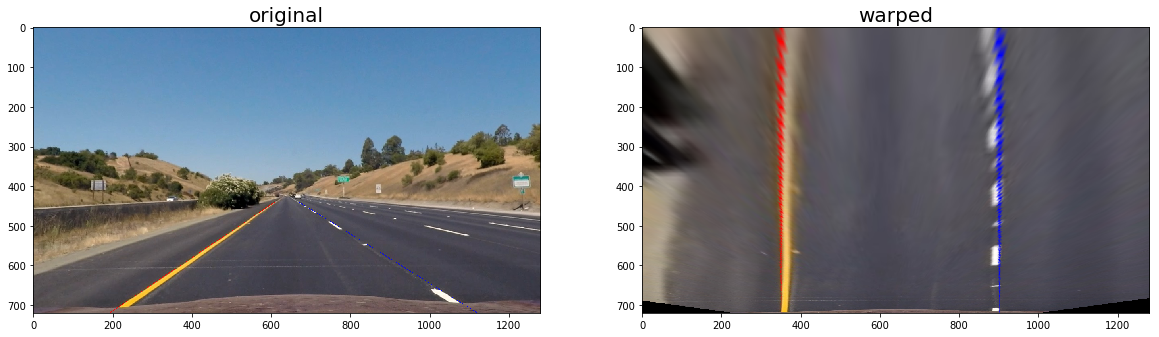

In [4]:
# Choosing parameters for perpective transformation
fname = './test_images/straight_lines1.jpg'
img = mpimg.imread(fname)

img_undistorted = undistort(img)
img_height = img_undistorted.shape[0]

lx1 = 192
ly1 = img_height
lx2 = 609
ly2 = 440
cv2.line(img_undistorted, (lx1, ly1), (lx2, ly2), color=[255,0,0], thickness=1)

rx1 = 1120
ry1 = img_height
rx2 = 670
ry2 = 440
cv2.line(img_undistorted, (rx1, ry1), (rx2, ry2), color=[0,0,255], thickness=1)

src = np.float32([
    [lx1, ly1], # bottom left
    [lx2, ly2], # top left
    [rx2, ry2], # top right
    [rx1, ry1]  # bottom right
]) 

dst = np.float32([
    [350, img_height], # bottom left
    [350, 0],          # top left
    [900, 0],          # top right
    [900, img_height]  # bottom right
])

M = cv2.getPerspectiveTransform(src, dst)
Minv = np.linalg.inv(M)

img_size = (img_undistorted.shape[1], img_undistorted.shape[0])
img_warped = cv2.warpPerspective(img_undistorted, M, img_size, flags=cv2.INTER_LINEAR)

print_image_grid([('original', img_undistorted), ('warped', img_warped)], 2)

## And define a method for the transformation

In [5]:
def birds_eye_view(img):
    img_size = (img.shape[1], img.shape[0])
    img_warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return img_warped

## Next step is defining a pipeline for processing a single image frame

In [6]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
def to_hls(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
def scale_sobel(abs_sobel):
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    return scaled_sobel
    
def gray_to_sobel(gray, orient='x', ksize=3):
    if orient == 'x':
        ox = 1
        oy = 0
    else:
        ox = 0
        oy = 1
    return cv2.Sobel(gray, cv2.CV_64F, ox, oy, ksize=ksize)
    
def gray_to_scaled_sobel(gray, orient='x', ksize=3):
    sobel = gray_to_sobel(gray, orient, ksize)
    abs_sobel = np.absolute(sobel)
    return scale_sobel(abs_sobel)
    
def gray_to_scaled_mag(gray, ksize=3):
    sobelx = gray_to_sobel(gray, 'x', ksize)
    sobely = gray_to_sobel(gray, 'y', ksize)    
    sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    return scale_sobel(sobel)
    
def bin_mask(img, thresh=[0, 255]):
    bin_img = np.zeros_like(img)
    bin_img[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return bin_img
    
def grad_direction(gray, ksize=3):
    """
    An orientation of 0 implies a vertical line and orientations of +/−π/2 imply horizontal lines
    """
    sobelx = gray_to_sobel(gray, 'x', ksize)
    sobely = gray_to_sobel(gray, 'y', ksize)    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)    
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    return grad_dir

def thresh(img):
    """
    returns a thresholded image and a list of steps
    """
    steps = []
    
    gray = grayscale(img)
    steps.append(('gray', gray))
    
    # RGB
    img_r = img[:,:,0]
    steps.append(('RGB_R', img_r))
    img_g = img[:,:,1]
    steps.append(('RGB_G', img_g))    
    img_b = img[:,:,2]    
    steps.append(('RGB_B', img_b))    
    
    # HLS
    hls = to_hls(img)
    hls_h = hls[:,:,0]
    steps.append(('HLS_H', hls_h))
    hls_l = hls[:,:,1]
    steps.append(('HLS_L', hls_l))
    hls_s = hls[:,:,2]
    steps.append(('HLS_S', hls_s))    
    
    # sobel x, y, magnitude
    sobelx = gray_to_scaled_sobel(gray, 'x')
    steps.append(('Gray-Sobel X', sobelx))
    sobely = gray_to_scaled_sobel(gray, 'y')
    steps.append(('Gray-Sobel Y', sobely))
    mag = gray_to_scaled_mag(gray)
    steps.append(('Gray-Sobel MAG', mag))
    
    hls_s_thresh = bin_mask(hls_s, thresh=[170, 255])
    steps.append(('HLS_S thresh', hls_s_thresh))    
    
    return (hls_s_thresh, steps)

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


In [11]:
def pipeline(img):
    steps = []
    
    steps.append(('original', img))
    
    # Applying a distortion correction to the raw image.
    img_undist = undistort(img)
    steps.append(('undistorted', img_undist))
    
    # Use color transforms, gradients, etc., to create a thresholded binary image.
    img_thresholded, thr_steps = thresh(img_undist)
    steps.extend(thr_steps)
    
    # Apply a perspective transform to rectify binary image ("birds-eye view").
    img_warped = birds_eye_view(img_thresholded)
    steps.append(('warped', img_warped))
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(img_warped)
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # Determine the curvature of the lane and vehicle position with respect to center.
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    
        # Generate x and y values for plotting
        ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    
    
        l_pts = np.vstack((left_fitx,ploty)).astype(np.int32).T
        r_pts = np.vstack((right_fitx,ploty)).astype(np.int32).T
        cv2.polylines(out_img, [l_pts], isClosed=False, color=[255,255,0])
        cv2.polylines(out_img, [r_pts], isClosed=False, color=[255,255,0])
    except Exception:
        pass
    
    steps.append(('lane pixels', out_img))
    

    # Warp the detected lane boundaries back onto the original image
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_undist, 1, newwarp, 0.3, 0)
    steps.append(('result', result))
    
    #print_image_grid(steps, 2)
    return result

# Testing the pipeline on test images

Processing  ./test_images/test6.jpg
Processing  ./test_images/test5.jpg
Processing  ./test_images/test4.jpg
Processing  ./test_images/test1.jpg
Processing  ./test_images/test3.jpg
Processing  ./test_images/test2.jpg
Processing  ./test_images/straight_lines2.jpg
Processing  ./test_images/straight_lines1.jpg


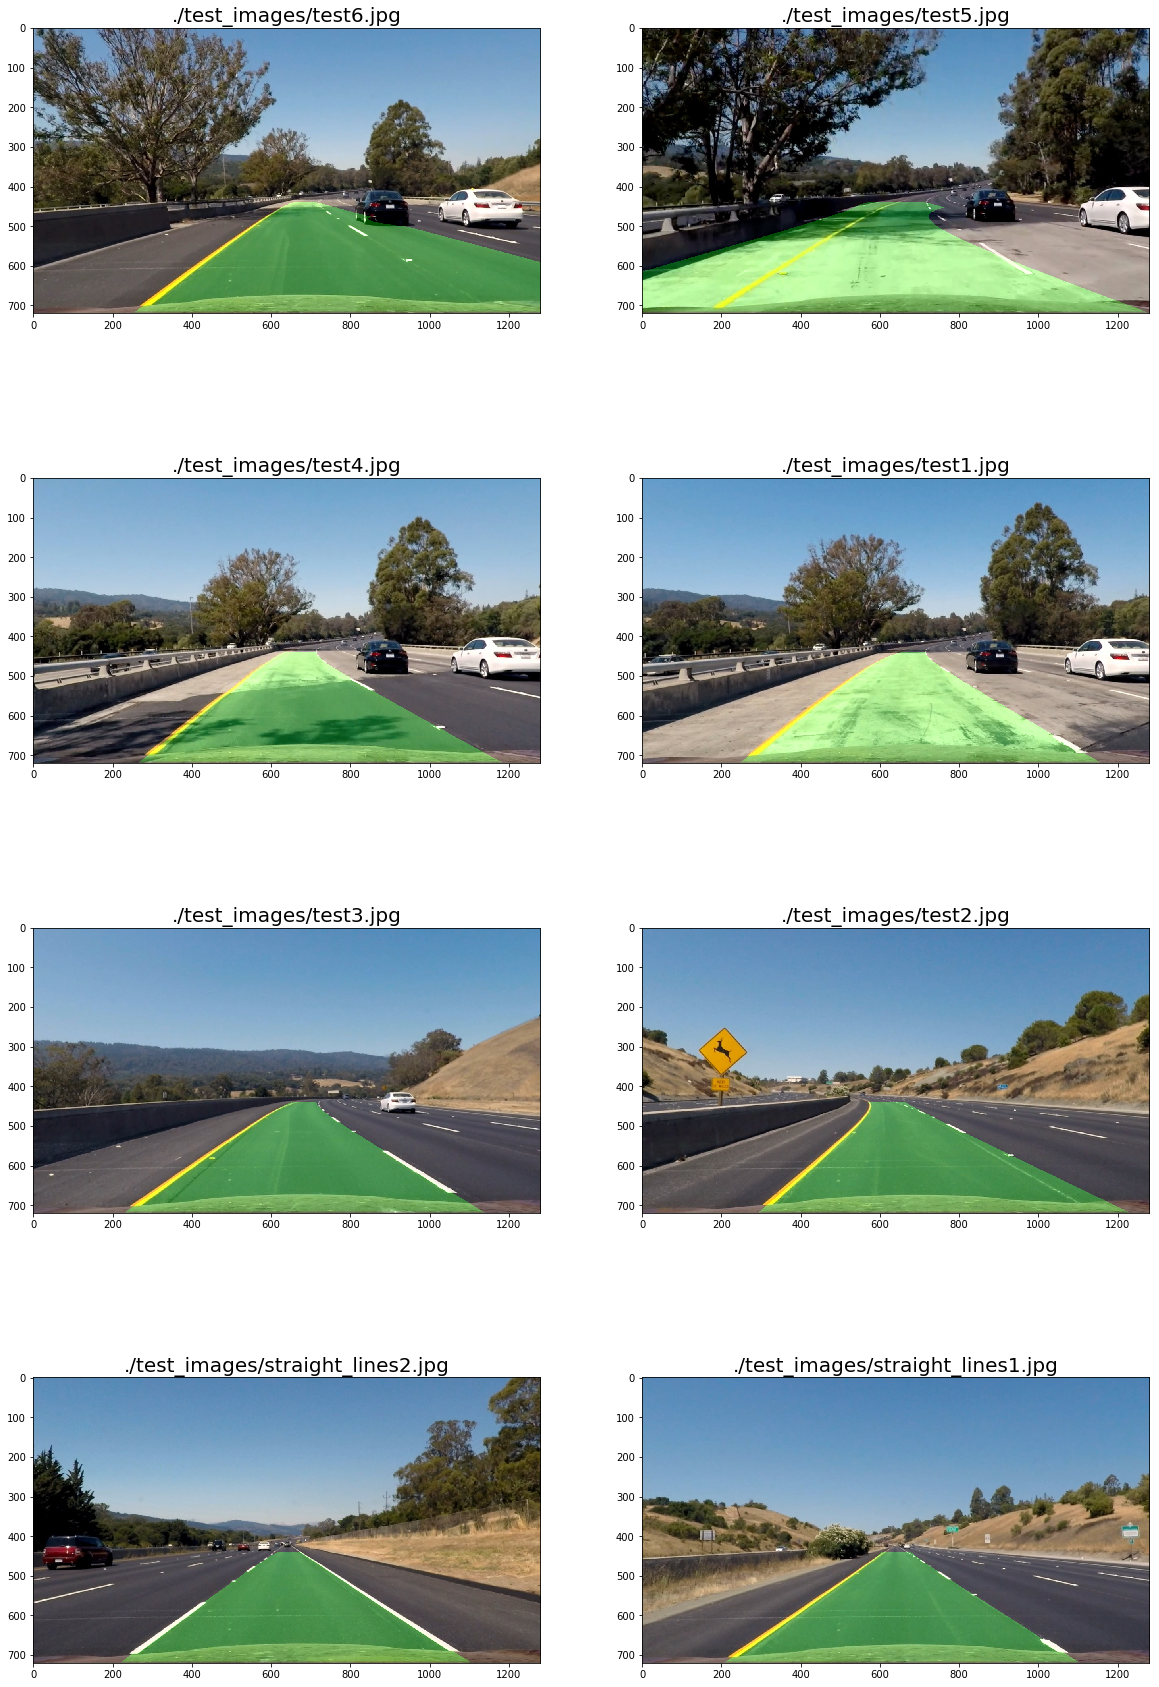

In [8]:
test_images = glob.glob('./test_images/*.jpg')
results = []
for fname in test_images:
    #if fname != './test_images/straight_lines2.jpg':
    #    continue
    print('Processing ', fname)
    img = mpimg.imread(fname)
    result = pipeline(img)
    results.append((fname, result))
    #break
print_image_grid(results, 2)

# Applying the pipeline to the project video

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    return pipeline(image)

In [12]:
white_output = 'output_videos/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(0,5) # the first five seconds for debugging
#clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4



 99%|█████████▉| 125/126 [00:14<00:00,  8.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 18.7 s, sys: 2.65 s, total: 21.4 s
Wall time: 15.4 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))